<a href="https://colab.research.google.com/github/skatsushi/Homocloud_Sample/blob/main/ml_pc_ja_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習チュートリアル (ポイントクラウド版)

このチュートリアルはポイントクラウドデータに対して機械学習とパーシステントホモロジーを組み合わせて適用するやりかたについて解説します．

sklearn (https://scikit-learn.org/stable/index.html) を利用します．

次のセルでHomCloudを Colaboratory にインストールします．次のセルを実行してください．

In [ ]:
!apt-get update
!apt-get install -qq xvfb
!pip install "pyvista[all,trame]==0.40.0" trame-vuetify trame jupyter_bokeh  # This is workaround for Colab, "panel" is only available interactive backend but the backend is removed in the latest pyvista
!pip install homcloud
!python3 -m homcloud.self_check

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1

利用するライブラリを読み込みます．

In [ ]:
import os  # for makedirs
import homcloud.interface as hc  # HomCloud
import numpy as np  # Numerical array library
from tqdm.notebook import tqdm  # For progressbar
import matplotlib.pyplot as plt  # Plotting
import sklearn.linear_model as lm  # Machine learning
from sklearn.decomposition import PCA  # for PCA
from sklearn.model_selection import train_test_split

PyVistaによる3次元可視化のセットアップをします．

In [ ]:
# VM内で Xvfb を起動
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

# pyvista のウィジットの利用を許可する
from google.colab import output
output.enable_custom_widget_manager()

# panel backend を活性化する
import pyvista as pv
pv.set_jupyter_backend("panel")
pv.global_theme.notebook = True

<ipython-input-3-0d700f1ac6c7>:12: PyVistaDeprecationWarning: `panel` backend is deprecated and is planned for future removal.
  pv.set_jupyter_backend("panel")


## 例題のデータの読み込み
例題のデータを読み込みます．

In [ ]:
import gdown
gdown.download("https://drive.google.com/uc?id=1C3KvVnxL2p3hZDFNYe3AQ_SWhtLmRWEr", "ml_pc.zip", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1C3KvVnxL2p3hZDFNYe3AQ_SWhtLmRWEr
To: /content/ml_pc.zip
100%|██████████| 6.80M/6.80M [00:00<00:00, 27.2MB/s]


'ml_pc.zip'

In [ ]:
# Zipファイルを展開する
!unzip ml_pc.zip

Archive:  ml_pc.zip
   creating: pc/
  inflating: pc/0159.txt             
  inflating: pc/0099.txt             
  inflating: pc/label.txt            
  inflating: pc/0118.txt             
  inflating: pc/0072.txt             
  inflating: pc/0000.txt             
  inflating: pc/0162.txt             
  inflating: pc/0107.txt             
  inflating: pc/0034.txt             
  inflating: pc/0025.txt             
  inflating: pc/0109.txt             
  inflating: pc/0133.txt             
  inflating: pc/0019.txt             
  inflating: pc/0059.txt             
  inflating: pc/0170.txt             
  inflating: pc/0091.txt             
  inflating: pc/0114.txt             
  inflating: pc/0193.txt             
  inflating: pc/0119.txt             
  inflating: pc/0131.txt             
  inflating: pc/0092.txt             
  inflating: pc/0135.txt             
  inflating: pc/0035.txt             
  inflating: pc/0010.txt             
  inflating: pc/0097.txt             
  inflating: 

## 機械学習を始める前に
まずはデータがどんなものか確認していきます。チュートリアル用のデータは `pc` というディレクトリ以下にあります。

In [ ]:
ls pc/

0000.txt  0021.txt  0042.txt  0063.txt  0084.txt  0105.txt  0126.txt  0147.txt  0168.txt  0189.txt
0001.txt  0022.txt  0043.txt  0064.txt  0085.txt  0106.txt  0127.txt  0148.txt  0169.txt  0190.txt
0002.txt  0023.txt  0044.txt  0065.txt  0086.txt  0107.txt  0128.txt  0149.txt  0170.txt  0191.txt
0003.txt  0024.txt  0045.txt  0066.txt  0087.txt  0108.txt  0129.txt  0150.txt  0171.txt  0192.txt
0004.txt  0025.txt  0046.txt  0067.txt  0088.txt  0109.txt  0130.txt  0151.txt  0172.txt  0193.txt
0005.txt  0026.txt  0047.txt  0068.txt  0089.txt  0110.txt  0131.txt  0152.txt  0173.txt  0194.txt
0006.txt  0027.txt  0048.txt  0069.txt  0090.txt  0111.txt  0132.txt  0153.txt  0174.txt  0195.txt
0007.txt  0028.txt  0049.txt  0070.txt  0091.txt  0112.txt  0133.txt  0154.txt  0175.txt  0196.txt
0008.txt  0029.txt  0050.txt  0071.txt  0092.txt  0113.txt  0134.txt  0155.txt  0176.txt  0197.txt
0009.txt  0030.txt  0051.txt  0072.txt  0093.txt  0114.txt  0135.txt  0156.txt  0177.txt  0198.txt
0010.txt  

`0000.txt` から `0199.txt` まで 200個のテキストデータがあります。また、`label.txt`には 0 か 1 のラベルデータがあり、
これは対象のデータが2つのグループに分けられていることを示しています。

では、ラベルを読み込んで表示します。

In [ ]:
labels = np.loadtxt("pc/label.txt")
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

これは 200個の 0/1の配列です。では、どのデータが0/1でラベル付けされているのかを確認しましょう。 numpy の機能を使います。

In [ ]:
np.nonzero(labels == 0), np.nonzero(labels == 1)

((array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
         68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
         85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),),
 (array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
         113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
         152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
         165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
         178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
         191, 192, 193, 

0 から 99 までが 0 で、100から199までが 1 で、それぞれラベル付けられていることがわかります。


## ポイントクラウドデータの読み込み
ではファイルからポイントクラウドデータを読み込みます。

In [ ]:
pointclouds = [np.loadtxt("pc/{:04d}.txt".format(i)) for i in tqdm(range(200))]

  0%|          | 0/200 [00:00<?, ?it/s]

0番目のデータの「形」を見ると 1000x3 となっていることがわかります。これは3次元上の点が1000個あることを意味します。
どのポイントクラウドも同じです。パーシステント図による機械学習では点の個数は同じくらいでないとあまりうまくいかない
(不可能ではないが注意点が多くなる)ことに注意しましょう。

In [ ]:
pointclouds[0].shape

(1000, 3)

0番目のデータを100番目のデータを可視化してみましょう。PyVistaの機能を使って横に並べてプロットします．

In [ ]:
pl = pv.Plotter(shape=(1, 2))
pl.subplot(0, 0)
pl.add_mesh(pv.PointSet(pointclouds[0]))
pl.subplot(0, 1)
pl.add_mesh(pv.PointSet(pointclouds[100]))
pl.show()

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

二種類のポイントクラウドの違いは可視化しただけでは見付けるのが難しそうです．この違いを見付けるためにパーシステントホモロジーと機械学習との組み合わせを利用します．

## パーシステント図の計算

では、HomCloudでパーシステント図を計算します。
計算したファイルは `pd` というディレクトリに保存しておきます。

保存しておいたデータは再利用できるので、別の解析をする場合などにはいちいち計算しなおすことなく利用できます。


In [ ]:
os.makedirs("pd", exist_ok=True)  # 保存先のディレクトリを作成
for i in tqdm(range(200)):
    hc.PDList.from_alpha_filtration(pointclouds[i], save_boundary_map=True, save_to="pd/{:04d}.pdgm".format(i))

  0%|          | 0/200 [00:00<?, ?it/s]

このチュートリアルでは2次のパーシステント図を使います。つまり空隙構造に注目していきます。
もちろん1次や0次なども使えますが、実はこのデータは2次の所に一番特徴があるのでこうします。

より高度な解析法として、1次と2次を同時に使う方法もあります。

In [ ]:
pds = [hc.PDList("pd/{:04d}.pdgm".format(i)).dth_diagram(2) for i in range(200)]

とりあえず計算したパーシステント図を表示してみます。0番目(ラベル0)と100番目(ラベル1)を表示します。

この図に何からの重要な幾何的特徴が抽出されている，と我々は期待しているわけです．

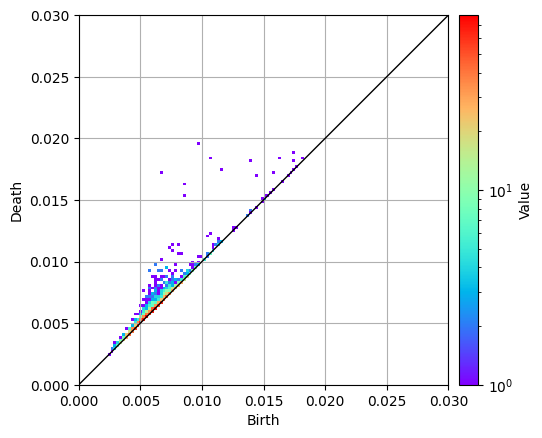

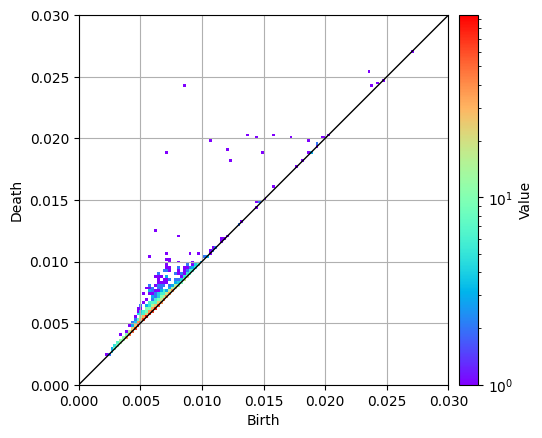

In [ ]:
pds[0].histogram(x_range=(0, 0.03)).plot(colorbar={"type": "log"})
pds[100].histogram(x_range=(0, 0.03)).plot(colorbar={"type": "log"})

## Persistence Image (PI) でベクトル化

Persistence Image については https://arxiv.org/abs/1507.06217 http://www.jmlr.org/papers/volume18/16-337/16-337.pdf を参考にしてください。
ただし、ここで説明するやりかたはこの論文の手法そのままではなく、 https://arxiv.org/abs/1706.10082 https://link.springer.com/article/10.1007%2Fs41468-018-0013-5
で用いられている改変版です。

まずはベクトル化の仕様を決めます。
`(0, 0.03), 128` で `[0, 0.03]x[0, 0.03]` という正方形内を128x128に分割して計算することを指定します。
`sigma=0.002` はガウス分布の標準偏差を指定します。また、`weight=("atan", 0.01, 3)` で対角線からの距離による重みの変化を
指定します。この場合の重みを決めるルールは $\textrm{atan} (0.01 \cdot \ell^3)$ です。ただし$\ell$はlifetime(=birth-death)を意味
します。

これらのパラメータはもちろん学習性能に影響します．クロスバリデーションなどの方法を用いて良いパラメータを探す必要がある場合は多いでしょう．

In [ ]:
spec = hc.PIVectorizeSpec((0, 0.03), 128, sigma=0.002, weight=("atan", 0.01, 3))

ではパーシステント図をベクトル化しましょう

In [ ]:
pdvects = np.vstack([spec.vectorize(pd) for pd in pds])

ベクトルの要素の最大最小を見ると$10^{-10}$と非常に小さいです。これは機械学習に悪い影響を与えるので正規化しておきます。

In [ ]:
pdvects.min(), pdvects.max()

(0.0, 2.099302720413663e-10)

In [ ]:
pdvects = pdvects / pdvects.max()

ベクトル化した結果をPDのヒストグラムに戻すことができます．このようにしてガウシアンフィルタの影響や対角線近傍のカットオフの影響を可視化することができます．

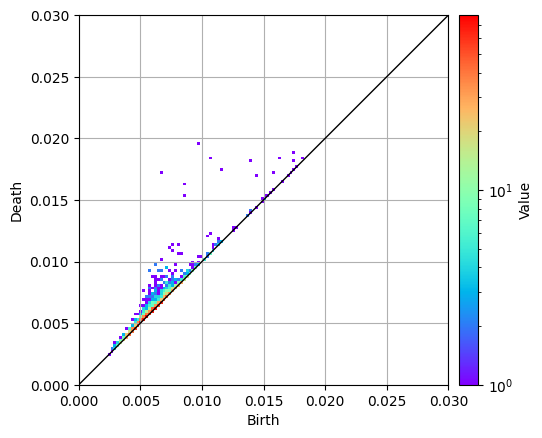

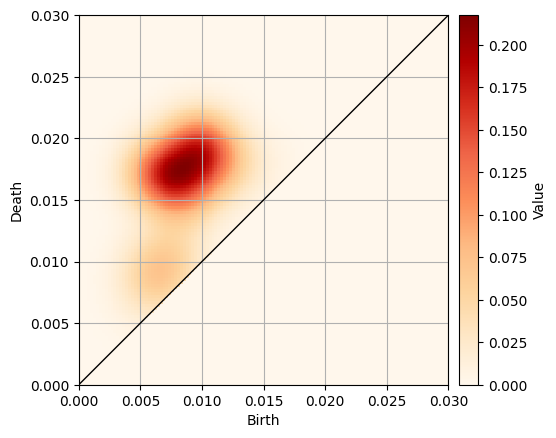

In [ ]:
pds[0].histogram(x_range=(0, 0.03)).plot(colorbar={"type": "log"})
spec.histogram_from_vector(pdvects[0, :]).plot(colorbar={"type": "linear"})

## 主成分解析(PCA)

まずはPCAを使って解析します。PCAは高次元のデータをできるだけ情報を損わずに低次元に落とすための手法です。
あまり解析結果が破綻しないのでとりあえずパーシステント図との組み合わせでは試す価値があります。
パーシステント図との組み合わせにおいては、個々のパーシステント図を低い次元の点として表現でき、パーシステント図互いの
関係を理解しやすく表現します。

ここでは可視化しやすい2次元に落とします。

In [ ]:
pca = PCA(n_components=2)
pca.fit(pdvects)

PCA(n_components=2)

さてどのように2次元上に表現されているか可視化します。 赤がラベル0、青がラベル1です。

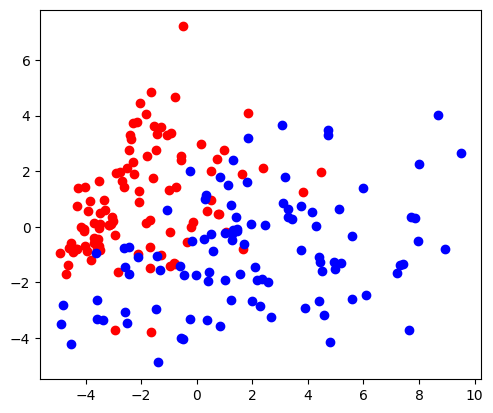

In [ ]:
reduced = pca.transform(pdvects)  # Project all vectors into R^2
plt.gca().set_aspect('equal')  # Set the aspect ratio of the figure
plt.scatter(reduced[labels == 0, 0], reduced[labels == 0, 1], c="r")  # Show 0-labled data by "r"ed
plt.scatter(reduced[labels == 1, 0], reduced[labels == 1, 1], c="b")  # Show 0-labled data by "b"lue

2次元平面上で赤と青がそれなりに分離できているようなので、ここでPIで計算したベクトルは2つのグループの間の違いをうまく表現できているようです。

ではこのX軸とY軸は何を表現しているのでしょうか？ここでは普通のPCAを使っているので、元の次元の所に
ベクトルがあり、各点がそのベクトルの成分をどれだけ含んでいるかを表しています。数式で書くと、
X軸、Y軸に対応するベクトル$v_1, v_2$があり、PIによる高次元ベクトル$w_i$($i$はデータごとのインデックスです)は
$$
w_i \approx \mu_{i1} v_1 + \mu_{i2} v_2 + v_0
$$
と近似されます(ただし$v_0$は$w_1,\ldots,$の平均)。このあたりはPCAの理論を勉強してください。
すると、$v_1, v_2$がどのようなベクトルであるかがわかればこの図の意味がわかるわけです。

sklearn の PCA では、$v_0$ が `PCA.mean_`, $v_1, v_2$ が `PCA.components_` に保存されています。

In [ ]:
pca.mean_

array([3.32287297e-05, 3.52588389e-05, 3.67793759e-05, ...,
       9.95550058e-08, 7.27036741e-08, 7.13024938e-08])

In [ ]:
pca.components_

array([[ 2.59806997e-07,  2.70363482e-07,  2.77565448e-07, ...,
        -3.62878022e-09, -4.09395688e-09, -3.50500694e-09],
       [-6.08939377e-07, -6.42464500e-07, -6.65625771e-07, ...,
         4.65980431e-09, -5.76173853e-10,  1.41943997e-09]])

PIの一つの利点として、ベクトルをパーシステント図に変換できる点があります。これを使うとこれら平均や$v_1, v_2$をパーシステント図の形で
可視化できます。実際にやってみましょう。ベクトル化で使った`hc.PIVectorizerMesh`のオブジェクトがこの変換(逆変換)のための情報を持っています。

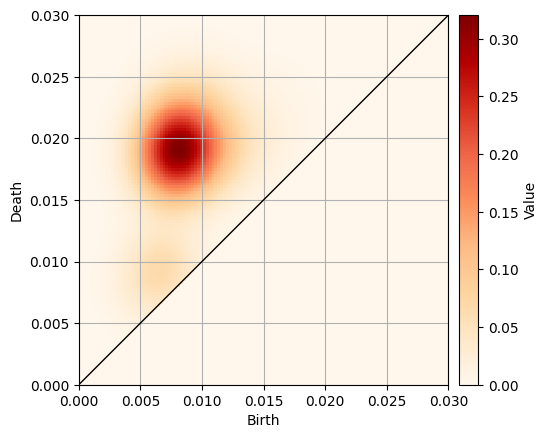

In [ ]:
spec.histogram_from_vector(pca.mean_).plot()

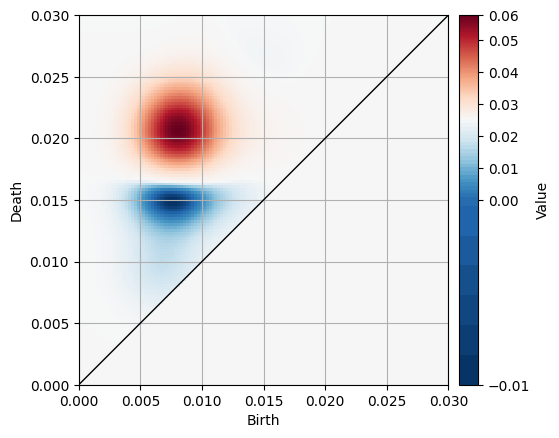

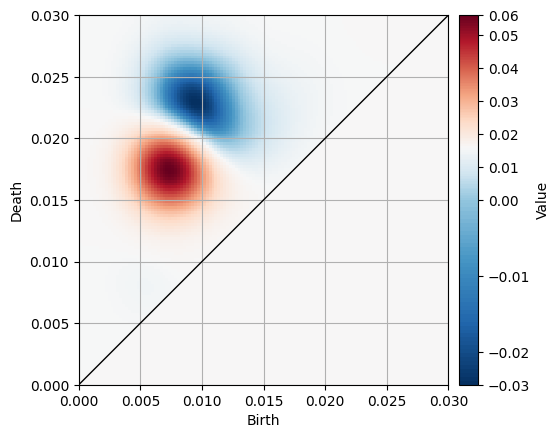

In [ ]:
spec.histogram_from_vector(pca.components_[0, :]).plot(colorbar={"type":"linear-midpoint", "midpoint": 0})
spec.histogram_from_vector(pca.components_[1, :]).plot(colorbar={"type":"linear-midpoint", "midpoint": 0})

PCAのベクトルの成分には±があり、それが各軸の±と対応しているので±が赤と黒に対応するよう表示させるとわかりやすいです。`colorbar={"type":"linear-midpoint", "midpoint": 0}`の部分で調整しています。ここからさらに
この赤い部分、青い部分、に含まれるbirth-death pairを取り出して、逆解析で取り出してさらなる解析をする、ということもできます。
この逆解析の部分は次のロジスティック回帰の部分で実習しましょう。

## ロジスティック回帰

次はロジスティック回帰です。ロジスティック回帰もPHとの組み合わせが比較的やりやすい手法です。
特に2クラス分類が解釈のしやすさもあってやりやすいです。

まず学習をする前にテスト用データ(test set)と学習用データ(training set)に分けます。

In [ ]:
pdvects_train, pdvects_test, labels_train, labels_test = train_test_split(pdvects, labels, test_size=0.25)

学習用データで学習します。sklearnの`LogisitcRegression`というクラスを使います。正則化パラメータ`C`はここでは
あらかじめ適当なものを選んでいますが、`LogisitcRegressionCV`というクラスを使って交差検証を使って自動的にパラメータを
決めることもできます。

In [ ]:
model = lm.LogisticRegression(C=0.01, solver="lbfgs")

In [ ]:
model.fit(pdvects_train, labels_train)

LogisticRegression(C=0.01)

テスト用データを使って性能を確認します。

In [ ]:
model.score(pdvects_test, labels_test)

0.9

なかなか良さそうな精度です(0.8前後になるはずです)。では、学習結果を可視化します。

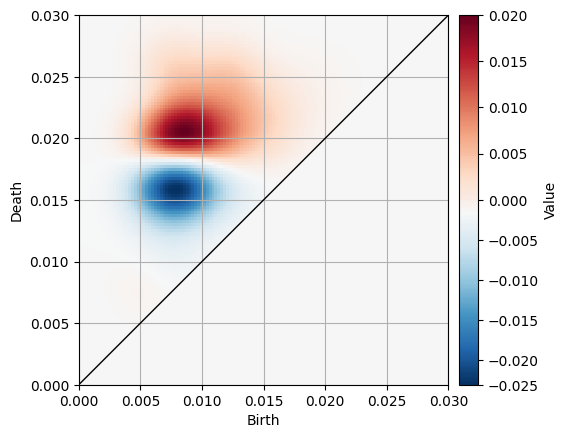

In [ ]:
spec.histogram_from_vector(model.coef_.ravel()).plot(colorbar={"type": "linear-midpoint", "midpoint": 0.0})

この図の見方ですが、濃い赤の領域に沢山birth-death pairがあるデータはラベル1である可能性が高く、
濃い青の領域に沢山birth-death pairがあるデータはラベル0である可能性が高いことを意味します。

## 逆解析 (Optimal volume)
ではこの赤/青の領域を抽出しましょう。 値が0.005を基準として、0.005より大、-0.005より小、の部分を切り出します。
これには numpy の不等号演算が役立ちます。

In [ ]:
coef = model.coef_.ravel()

In [ ]:
red_area = spec.mask_from_vector(coef > 0.005)

In [ ]:
blue_area = spec.mask_from_vector(coef < -0.005)

取り出した領域を可視化します。

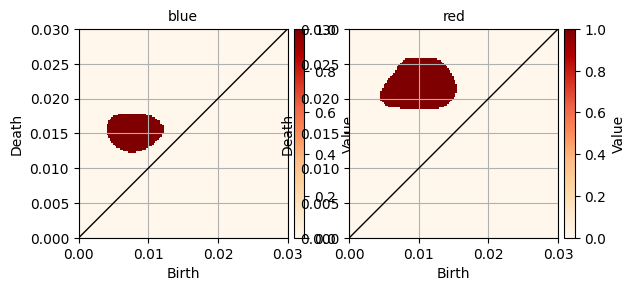

In [ ]:
blue_area.plot(title="blue", ax=plt.subplot(1, 2, 1))
red_area.plot(title="red", ax=plt.subplot(1, 2, 2))

取り出した領域に含まれているbirth-death pairを0番目のPD(ラベル0)100番目のPD(ラベル1)から取り出します。

In [ ]:
pairs_in_blue_0 = blue_area.filter_pairs(pds[0].pairs())
pairs_in_red_0 = red_area.filter_pairs(pds[0].pairs())

In [ ]:
pairs_in_blue_100 = blue_area.filter_pairs(pds[100].pairs())
pairs_in_red_100 = red_area.filter_pairs(pds[100].pairs())

個数を表示しましょう。

In [ ]:
len(pairs_in_blue_0), len(pairs_in_red_0), len(pairs_in_blue_100), len(pairs_in_red_100)

(3, 1, 0, 6)

確かに0番目PDには青い領域にあるpairが多く、100番目PDには赤い領域にあるpairが多いようです。実際に見てみると以下のようなpairのようです。

In [ ]:
pairs_in_blue_0

[Pair(0.008484743298521374, 0.015315059365253271),
 Pair(0.0086407914437143, 0.01634538350339904),
 Pair(0.006687816186736094, 0.01715384087925338)]

さて、ここでoptimal volumeを計算して可視化してみます (Stable volumeを代わりに使うのも良いアイデアです)。
これによってどのような空隙が分類に重要な役割を果たしているのか可視化できます。


In [ ]:
optimal_volumes_blue_0 = [pair.optimal_volume(cutoff_radius=0.4) for pair in pairs_in_blue_0]
optimal_volumes_red_100 = [pair.optimal_volume(cutoff_radius=0.4) for pair in pairs_in_red_100]

In [ ]:
pl = pv.Plotter(shape=(1, 2))
pl.subplot(0, 0)
pl.add_mesh(pv.PointSet(pointclouds[0]))
for ov in optimal_volumes_blue_0:
    pl.add_mesh(ov.to_pyvista_boundary_mesh(), color="blue")
pl.subplot(0, 1)
pl.add_mesh(pv.PointSet(pointclouds[100]))
for ov in optimal_volumes_red_100:
    pl.add_mesh(ov.to_pyvista_boundary_mesh(), color="red")
pl.show()

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

ちょっとわかりにくい気もするので2つ重ねて表示してみます。

In [ ]:
pl = pv.Plotter()
for ov in optimal_volumes_blue_0:
    pl.add_mesh(ov.to_pyvista_boundary_mesh(), color="blue", opacity=0.5)
for ov in optimal_volumes_red_100:
    pl.add_mesh(ov.to_pyvista_boundary_mesh(), color="red", opacity=0.5)
pl.show()

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

青い空隙がラベル0に「典型的」な空隙で、赤い空隙がラベル1に「典型的」な空隙です。

青のほうが赤よりちょっと細い感じがすると思います。学習結果のパーシステント図を見ると、
青い領域は赤い領域よりY軸(death)で小さいほうにあります。実は2次のパーシステント図において、
deathはその空隙に収まる最大の球の半径の2乗に対応しています。つまりこの学習結果は
ラベル1のほうがこのスケールの隙間が大きい、ことを意味しています。
赤い領域の中心のdeathが0.022、青い領域の中心が0.017くらいですので、
それぞれの平方根、つまり

In [ ]:
np.sqrt(0.017), np.sqrt(0.022)

(0.130384048104053, 0.14832396974191325)

あたりがそれぞれのグループの特徴的空隙のスケールである、ということがわかります。


元々のパーシステント図を眺めると、もっと小さい空隙はどちらも共通に沢山ある、ということも見てとれます。

以上でこのチュートリアルは終わりです。